In [215]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [216]:
#安裝geopandas有許多坑，很容易error，可以參考 https://zhuanlan.zhihu.com/p/137628480，文中地3個方法
#地理資料相關
import geopandas as gpd
from geopandas import GeoDataFrame, GeoSeries

from shapely import geos, geometry
from shapely.geometry import shape,LineString,Point,Polygon

import fiona
from fiona.crs import from_epsg,from_string

#繪圖相關
import folium
from folium import IFrame
from folium.plugins import MarkerCluster

#顏色相關
import seaborn as sns
import branca

In [217]:
# GIS編碼轉換
def trans(gdf):
    gdf.crs = {'init' :'epsg:3824'} # 避免資料沒設，這邊再重新給一次
    gdf=gdf.to_crs({'init' :'epsg:4326'})
    return gdf
# 中文顯示
def utf2asc(s):
    return str(str(s).encode('ascii', 'xmlcharrefreplace'))[2:-1]
heading3 = """<h3>{}</h3>""".format

# 村里邊界資料整理

In [218]:
#匯入台灣村里邊界資料  https://whgis.nlsc.gov.tw/Opendata/Files.aspx
gdf=gpd.read_file(r'C:/Users/RT009223/GIS/村里/VILLAGE_MOI_1090423.shp',encoding='utf-8')
gdf=gdf.loc[:,['COUNTYNAME','TOWNNAME','VILLNAME','geometry']]
gdf=trans(gdf)
print(gdf.shape)
gdf=gdf.dropna().reset_index(drop=True)
gdf.columns=['縣市','行政區','村里','geometry']
print(gdf.shape)
gdf.head(5)

(7965, 4)
(7760, 4)


,縣市,行政區,村里,geometry
0,高雄市,林園區,中門里,"POLYGON ((120.36772 22.49564, 120.36427 22.498..."
1,高雄市,林園區,港埔里,"POLYGON ((120.37325 22.49123, 120.37147 22.492..."
2,高雄市,旗津區,上竹里,"POLYGON ((120.28976 22.57317, 120.28577 22.577..."
3,高雄市,旗津區,中興里,"POLYGON ((120.30320 22.55568, 120.30284 22.557..."
4,連江縣,南竿鄉,津沙村,"POLYGON ((119.91684 26.14109, 119.91683 26.141..."


# 會員資料

## 地址不完整

In [219]:
import os
os.chdir(r'C:\Users\RT009223\TestriteGroup\滲透率專案\02_adjusted data')

In [220]:
df_get_back=pd.read_table(r'C:\Users\RT009223\TestriteGroup\滲透率專案\02_adjusted data\1A39會員位置(無正確地址的資料)_一般卡_2020Q4.txt',sep=',')
print(df_get_back.shape)
df_get_back=df_get_back.drop_duplicates(subset=['id']).reset_index(drop=True)
print(df_get_back.shape)
unsure=df_get_back.shape[0]
df_get_back=df_get_back[-df_get_back['村里'].isna()].reset_index(drop=True)
print(df_get_back.shape)
unsure_get_back=df_get_back.shape[0]

(5780, 4)
(5780, 4)
(89, 4)


## 地址完整

In [221]:
result=pd.read_table(r'C:\Users\RT009223\TestriteGroup\滲透率專案\02_adjusted data\1A39會員位置(經整理_配對村里)_一般卡_2020Q4.txt',sep=',')
print(result.shape)
result=result.drop_duplicates(subset=['id']).reset_index(drop=True)
print(result.shape)
result.head()

(39422, 7)
(39422, 7)


,id,addr,lon,lat,縣市,行政區,村里
0,20071215000134,臺中市南屯區大興里18鄰大墩一街95巷6號 ...,120.650969,24.137479,台中市,南屯區,大興里
1,20100340076486,臺中市北區明德里17鄰忠明路327之2號 ...,120.666478,24.163069,台中市,北區,明德里
2,20120405000262,臺中市南屯區大同里11鄰大墩七街45號 ...,120.653750,24.143642,台中市,南屯區,大同里
3,20100340175296,臺中市南屯區田心里6鄰大墩四街326之12號 ...,120.646280,24.141336,台中市,南屯區,田心里
4,20121028000107,臺中市西區?龍里11鄰模範街26號 ...,120.666738,24.148754,台中市,西區,雙龍里


In [222]:
df_get_back=df_get_back[-df_get_back.id.isin(result.id)]
print(df_get_back.shape)

(89, 4)


In [223]:
result=pd.concat([result,df_get_back]).reset_index(drop=True)

In [224]:
used=result.shape[0]
new_total=used+(unsure-unsure_get_back)
new_loss=(unsure-unsure_get_back)/(used+(unsure-unsure_get_back))
print('total : ',new_total)
print('loss rate : ',new_loss)

total :  45202
loss rate :  0.1259015087827972


In [225]:
print('可用數目 : ',used)
print('不可用數目 : ',(unsure-unsure_get_back))

可用數目 :  39511
不可用數目 :  5691


## 調整會員數(較精細)

In [226]:
print('地址不完整')
df_sp0a=pd.read_table(r'C:\Users\RT009223\TestriteGroup\滲透率專案\02_adjusted data\1A39會員位置(無正確地址的資料)_一般卡_2020Q4.txt',sep=',')
print(df_sp0a.shape)
df_sp0a=df_sp0a.drop_duplicates(subset=['id']).reset_index(drop=True)
print(df_sp0a.shape)

print('===========================================')

print('地址完整')
df_sp0b=pd.read_table(r'C:\Users\RT009223\TestriteGroup\滲透率專案\02_adjusted data\1A39會員位置(經整理_配對村里)_一般卡_2020Q4.txt',sep=',')
print(df_sp0b.shape)
df_sp0b=df_sp0b.drop_duplicates(subset=['id']).reset_index(drop=True)
print(df_sp0b.shape)

print('===========================================')

print('不完整+完整')
df_sp_01=pd.concat([df_sp0b,df_sp0a]).reset_index(drop=True)
df_sp_01=df_sp_01.drop_duplicates(subset=['id']).reset_index(drop=True)
print(df_sp_01.shape)
df_sp_01.loc[df_sp_01['縣市'].isna(),['縣市']]='NA'
df_sp_01.loc[df_sp_01['行政區'].isna(),['行政區']]='NA'
df_sp_01.loc[df_sp_01['村里'].isna(),['村里']]='NA'
df_sp_01.head(2)

地址不完整
(5780, 4)
(5780, 4)
地址完整
(39422, 7)
(39422, 7)
不完整+完整
(45202, 7)


,id,addr,lon,lat,縣市,行政區,村里
0,20071215000134,臺中市南屯區大興里18鄰大墩一街95巷6號 ...,120.650969,24.137479,台中市,南屯區,大興里
1,20100340076486,臺中市北區明德里17鄰忠明路327之2號 ...,120.666478,24.163069,台中市,北區,明德里


In [227]:
df_sp_02=df_sp_01.groupby(['縣市','行政區','村里'])['id'].count().reset_index(name='n')
print(df_sp_01.shape[0])
print(df_sp_02.n.sum())
df_sp_02['c_list']=df_sp_02['縣市']
df_sp_02['t_list']=df_sp_02['縣市']+df_sp_02['行政區']
df_sp_02.head(2)

45202
45202


,縣市,行政區,村里,n,c_list,t_list
0,NA,NA,NA,3975,NA,NANA
1,南投縣,中寮鄉,NA,1,南投縣,南投縣中寮鄉


In [228]:
if (df_sp_02['縣市']=='NA').sum()>0:
    c_rate=df_sp_02.loc[(df_sp_02['縣市']=='NA'),'n'].values[0]/df_sp_02.n.sum()
    print('c_rate',c_rate)
    df_sp_02['n']=df_sp_02['n']/(1-c_rate)
    print(df_sp_02.head(2))
    df_sp_02=df_sp_02.loc[-(df_sp_02['縣市']=='NA'),:].reset_index(drop=True)
    print(df_sp_02.head(2))
    df_sp_02.n=df_sp_02.n/(df_sp_02.n.sum()/df_sp_01.shape[0])
    print(df_sp_02.n.sum())
else:
    print('沒有縣市NA值')

c_rate 0.08793858678819522
    縣市  行政區  村里            n c_list  t_list
0   NA   NA  NA  4358.259151     NA    NANA
1  南投縣  中寮鄉  NA     1.096417    南投縣  南投縣中寮鄉
    縣市  行政區   村里         n c_list  t_list
0  南投縣  中寮鄉   NA  1.096417    南投縣  南投縣中寮鄉
1  南投縣  中寮鄉  廣福村  1.096417    南投縣  南投縣中寮鄉
45202.0


In [229]:
if (df_sp_02['行政區']=='NA').sum()>0:
    c_list=df_sp_02.loc[(df_sp_02['行政區']=='NA'),:]['c_list'].unique()
    for c in c_list:
        t_rate=df_sp_02.loc[(df_sp_02['c_list']==c)&(df_sp_02['村里']=='NA'),'n'].values[0]/df_sp_02.loc[(df_sp_02['c_list']==c),'n'].sum()
        print(c,t_rate)
        df_sp_02.loc[(df_sp_02['c_list']==c)&-(df_sp_02['村里']=='NA'),'n']=df_sp_02.loc[(df_sp_02['c_list']==c)&-(df_sp_02['村里']=='NA'),'n']/(1-t_rate)
        df_sp_02=df_sp_02.loc[-((df_sp_02['c_list']==c)&(df_sp_02['村里']=='NA')),:].reset_index(drop=True)
        df_sp_02.n=df_sp_02.n/(df_sp_02.n.sum()/df_sp_01.shape[0])
        print(df_sp_02.n.sum())
else:
    print('沒有行政區NA值')

沒有行政區NA值


In [230]:
print(df_sp_02.n.sum())
df_sp_02.n=df_sp_02.n/(df_sp_02.n.sum()/df_sp_01.shape[0])
print(df_sp_02.n.sum())

45202.0
45202.0


In [231]:
if (df_sp_02['村里']=='NA').sum()>0:
    t_list=df_sp_02.loc[(df_sp_02['村里']=='NA'),:]['t_list'].unique()
    for t in t_list:
        v_rate=df_sp_02.loc[(df_sp_02['t_list']==t)&(df_sp_02['村里']=='NA'),'n'].values[0]/df_sp_02.loc[(df_sp_02['t_list']==t),'n'].sum()
        print(t,v_rate)
        df_sp_02.loc[(df_sp_02['t_list']==t)&-(df_sp_02['村里']=='NA'),'n']=df_sp_02.loc[(df_sp_02['t_list']==t)&-(df_sp_02['村里']=='NA'),'n']/(1-v_rate)
        df_sp_02=df_sp_02.loc[-((df_sp_02['t_list']==t)&(df_sp_02['村里']=='NA')),:].reset_index(drop=True)
else:
    print('沒有村里NA值')

南投縣中寮鄉 0.1
南投縣仁愛鄉 0.11764705882352941
南投縣信義鄉 0.07692307692307693
南投縣南投市 0.028469750889679717
南投縣名間鄉 0.03333333333333333
南投縣埔里鎮 0.027149321266968323
南投縣水里鄉 0.08695652173913043
南投縣竹山鎮 0.023255813953488372
南投縣草屯鎮 0.022292993630573243
南投縣魚池鄉 0.045454545454545456
台中市中區 0.41994750656167984
台中市北區 0.024303073624017155
台中市北屯區 0.03926096997690531
台中市南區 0.03217558065203495
台中市南屯區 0.020794701986754965
台中市后里區 0.051546391752577324
台中市外埔區 0.03125
台中市大安區 0.07142857142857144
台中市大甲區 0.03726708074534161
台中市大肚區 0.02380952380952381
台中市大里區 0.02770780856423174
台中市大雅區 0.056451612903225805
台中市太平區 0.026685393258426962
台中市新社區 0.04166666666666667
台中市東勢區 0.037735849056603765
台中市東區 0.03731343283582089
台中市梧棲區 0.05517241379310345
台中市沙鹿區 0.028776978417266185
台中市清水區 0.03684210526315789
台中市潭子區 0.04680851063829787
台中市烏日區 0.023537803138373753
台中市神岡區 0.05607476635514018
台中市西區 0.03409563409563409
台中市西屯區 0.07093946863872912
台中市豐原區 0.029739776951672858
台中市霧峰區 0.02409638554216868
台中市龍井區 0.05179282868525897
台北市中山區 0.04411764705

In [232]:
print(df_sp_02.n.sum())
df_sp_02.n=df_sp_02.n/(df_sp_02.n.sum()/df_sp_01.shape[0])
print(df_sp_02.n.sum())

45185.5537390545
45202.0


In [233]:
df_sp_02=df_sp_02.loc[:,['縣市','行政區','村里','n']]
df_sp_02.columns=['縣市','行政區','村里','會員數-adjusted']
df_sp_02.head(2)

,縣市,行政區,村里,會員數-adjusted
0,南投縣,中寮鄉,廣福村,1.218685
1,南投縣,中寮鄉,廣興村,2.437370


## 會員消費

In [234]:
sales=pd.read_csv(r'C:\Users\RT009223\TestriteGroup\滲透率專案\01_raw data\1A39_2020Q4一般卡會員消費金額.csv',error_bad_lines=False,header=None)
if sales.shape[1]==3:
    sales.columns=['id','site','sale']
elif sales.shape[1]==2:
    sales.columns=['id','sale']
else:
    print("something wrong")
print(sales.shape)

(45202, 2)


In [235]:
#是否要排出退貨
if 1==0:
    sales=sales[sales['sale']>0]
sales.head()

,id,sale
0,20101113000262,247.0
1,20130630000197,76.0
2,20030612000091,4997.0
3,20100340113226,1800.0
4,20180722000232,381.0


In [236]:
sales=sales.groupby(['id'])['sale'].sum().reset_index()
sales.sale.sum()

159855132.79

In [237]:
result[-result.id.isin(sales.id)]

,id,addr,lon,lat,縣市,行政區,村里


In [238]:
sales.id.isin(result.id).sum()

39511

## 合併

In [239]:
result=pd.merge(result,sales).reset_index(drop=True)

In [240]:
print(result.shape)
result.head()

(39511, 8)


,id,addr,lon,lat,縣市,行政區,村里,sale
0,20071215000134,臺中市南屯區大興里18鄰大墩一街95巷6號 ...,120.650969,24.137479,台中市,南屯區,大興里,1157.0
1,20100340076486,臺中市北區明德里17鄰忠明路327之2號 ...,120.666478,24.163069,台中市,北區,明德里,921.0
2,20120405000262,臺中市南屯區大同里11鄰大墩七街45號 ...,120.653750,24.143642,台中市,南屯區,大同里,1735.0
3,20100340175296,臺中市南屯區田心里6鄰大墩四街326之12號 ...,120.646280,24.141336,台中市,南屯區,田心里,445.0
4,20121028000107,臺中市西區?龍里11鄰模範街26號 ...,120.666738,24.148754,台中市,西區,雙龍里,1671.0


# 人口資料

In [241]:
pop=pd.read_excel(r'台灣202012年村里人口.xlsx')
print(pop.shape)
pop.head(5)

(7760, 5)


,縣市,行政區,村里,戶口,人口
0,高雄市,林園區,中門里,1130,2871
1,高雄市,林園區,港埔里,823,2040
2,高雄市,旗津區,上竹里,1372,3202
3,高雄市,旗津區,中興里,1065,2858
4,連江縣,南竿鄉,津沙村,114,459


# Merge

In [242]:
# 調整文字
gdf['縣市']=list(gdf['縣市'].apply(lambda x:x.replace('臺','台')))
gdf['行政區']=list(gdf['行政區'].apply(lambda x:x.replace('臺','台')))
gdf['村里']=list(gdf['村里'].apply(lambda x:x.replace('臺','台')))
gdf['村里']=gdf['村里'].apply(lambda x:x.replace('舘','館'))
gdf['村里']=gdf['村里'].apply(lambda x:x.replace('双','雙'))
gdf['村里']=gdf['村里'].apply(lambda x:x.replace('石[曹]里','石𥕢里'))
gdf['村里']=gdf['村里'].apply(lambda x:x.replace('鷄林里','雞林里'))
gdf['村里']=gdf['村里'].apply(lambda x:x.replace('水磜村','水祭村'))
gdf['村里']=gdf['村里'].apply(lambda x:x.replace('珊湖里','珊瑚里'))
gdf['村里']=gdf['村里'].apply(lambda x:x.replace('欍','瓊'))

pop['縣市']=list(pop['縣市'].apply(lambda x:x.replace('臺','台')))
pop['行政區']=list(pop['行政區'].apply(lambda x:x.replace('臺','台')))
pop['村里']=list(pop['村里'].apply(lambda x:x.replace('臺','台')))
pop['村里']=pop['村里'].apply(lambda x:x.replace('舘','館'))
pop['村里']=pop['村里'].apply(lambda x:x.replace('双','雙'))
pop['村里']=pop['村里'].apply(lambda x:x.replace('石[曹]里','石𥕢里'))
pop['村里']=pop['村里'].apply(lambda x:x.replace('鷄林里','雞林里'))
pop['村里']=pop['村里'].apply(lambda x:x.replace('水磜村','水祭村'))
pop['村里']=pop['村里'].apply(lambda x:x.replace('珊湖里','珊瑚里'))
pop['村里']=pop['村里'].apply(lambda x:x.replace('欍','瓊'))
pop['村里']=pop['村里'].apply(lambda x:x.replace('溝垻里','溝埧里'))
pop['村里']=pop['村里'].apply(lambda x:x.replace('崙峰里','崙峯里'))

result['縣市']=list(result['縣市'].apply(lambda x:x.replace('臺','台')))
result['村里']=result['村里'].astype('str')
result['村里']=result['村里'].apply(lambda x:x.replace('舘','館'))
result['村里']=result['村里'].apply(lambda x:x.replace('石[曹]里','石𥕢里'))
result['村里']=result['村里'].apply(lambda x:x.replace('双','雙'))
result['村里']=result['村里'].apply(lambda x:x.replace('鷄林里','雞林里'))
result['村里']=result['村里'].apply(lambda x:x.replace('水磜村','水祭村'))
result['村里']=result['村里'].apply(lambda x:x.replace('珊湖里','珊瑚里'))
result['村里']=result['村里'].apply(lambda x:x.replace('欍','瓊'))

In [243]:
# 確認是否有錯誤
print(result[-(result['縣市']+result['行政區']+result['村里']).isin(pop['縣市']+pop['行政區']+pop['村里'])]['縣市'].unique())
print(pop[-(pop['行政區']+pop['村里']).isin(gdf['行政區']+gdf['村里'])])

[]
Empty DataFrame
Columns: [縣市, 行政區, 村里, 戶口, 人口]
Index: []


In [244]:
if 'sale' in result.columns:
    result2=result.groupby(['縣市','行政區','村里']).agg({'id':'count','sale':'sum'}).reset_index()
    result2.columns=['縣市','行政區','村里','會員數','消費額']
else:
    result2=result.groupby(['縣市','行政區','村里'])['id'].count().reset_index()
    result2.columns=['縣市','行政區','村里','會員數']

print(result2.shape)
result2.head()

(4124, 5)


,縣市,行政區,村里,會員數,消費額
0,南投縣,中寮鄉,廣福村,1,56.0
1,南投縣,中寮鄉,廣興村,2,2652.0
2,南投縣,中寮鄉,永平村,3,2094.0
3,南投縣,中寮鄉,永福村,1,1490.0
4,南投縣,中寮鄉,爽文村,1,214.0


In [245]:
result2=pd.merge(pop,result2,how='left')
print(result2.shape)

(7760, 7)


In [246]:
print(result2[-(result2['縣市']+result2['行政區']+result2['村里']).isin(pop['縣市']+pop['行政區']+pop['村里'])]['縣市'].unique())
print(pop[-(pop['行政區']+pop['村里']).isin(gdf['行政區']+gdf['村里'])])

[]
Empty DataFrame
Columns: [縣市, 行政區, 村里, 戶口, 人口]
Index: []


In [247]:
result2['會員數'].sum()

39511.0

In [248]:
gdf_final=pd.merge(gdf,result2,how='right')

In [249]:
gdf_final.head()

,縣市,行政區,村里,geometry,戶口,人口,會員數,消費額
0,高雄市,林園區,中門里,"POLYGON ((120.36772 22.49564, 120.36427 22.498...",1130,2871,NaN,NaN
1,高雄市,林園區,港埔里,"POLYGON ((120.37325 22.49123, 120.37147 22.492...",823,2040,1.0,1502.0
2,高雄市,旗津區,上竹里,"POLYGON ((120.28976 22.57317, 120.28577 22.577...",1372,3202,NaN,NaN
3,高雄市,旗津區,中興里,"POLYGON ((120.30320 22.55568, 120.30284 22.557...",1065,2858,1.0,650.0
4,連江縣,南竿鄉,津沙村,"POLYGON ((119.91684 26.14109, 119.91683 26.141...",114,459,NaN,NaN


# 計算

In [250]:
if '消費額' in gdf_final.columns:
    gdf_final['平均消費額']=round(gdf_final['消費額']/gdf_final['會員數'])

In [251]:
gdf_final['會員數'][gdf_final['會員數'].isna()]=0

In [252]:
gdf_final['site']=gdf_final['縣市']+gdf_final['行政區']+gdf_final['村里']

In [253]:
#gdf_final['會員數-adjusted']=gdf_final['會員數']/(1-new_loss)
gdf_final=pd.merge(gdf_final,df_sp_02,how='left')

In [254]:
gdf_final['會員數-adjusted'][gdf_final['會員數-adjusted'].isna()]=0
print(gdf_final['會員數-adjusted'].sum())

45202.00000000001


In [255]:
gdf_final['ratio']=gdf_final['會員數']/gdf_final['戶口']
gdf_final['ratio-adjusted']=gdf_final['會員數-adjusted']/gdf_final['戶口']

In [256]:
highest=0.6
gdf_final['ratio2']=gdf_final['ratio']
gdf_final.loc[gdf_final['ratio2']>highest,'ratio2']=highest
gdf_final['ratio2-adjusted']=gdf_final['ratio-adjusted']
gdf_final.loc[gdf_final['ratio2-adjusted']>highest,'ratio2-adjusted']=highest

In [257]:
gdf_final['會員數-show']=round(gdf_final['會員數']).astype('int')
gdf_final['會員數-adjusted-show']=round(gdf_final['會員數-adjusted']).astype('int')

In [258]:
gdf_final['percent']=gdf_final['ratio'].map(lambda x:str(round(x*100,1))+'%')
gdf_final['percent-adjusted']=gdf_final['ratio-adjusted'].map(lambda x:str(round(x*100,1))+'%')

In [259]:
gdf_final.head()

,縣市,行政區,村里,geometry,戶口,人口,會員數,消費額,平均消費額,site,會員數-adjusted,ratio,ratio-adjusted,ratio2,ratio2-adjusted,會員數-show,會員數-adjusted-show,percent,percent-adjusted
0,高雄市,林園區,中門里,"POLYGON ((120.36772 22.49564, 120.36427 22.498...",1130,2871,0.0,NaN,NaN,高雄市林園區中門里,0.000000,0.000000,0.000000,0.000000,0.000000,0,0,0.0%,0.0%
1,高雄市,林園區,港埔里,"POLYGON ((120.37325 22.49123, 120.37147 22.492...",823,2040,1.0,1502.0,1502.0,高雄市林園區港埔里,1.096816,0.001215,0.001333,0.001215,0.001333,1,1,0.1%,0.1%
2,高雄市,旗津區,上竹里,"POLYGON ((120.28976 22.57317, 120.28577 22.577...",1372,3202,0.0,NaN,NaN,高雄市旗津區上竹里,0.000000,0.000000,0.000000,0.000000,0.000000,0,0,0.0%,0.0%
3,高雄市,旗津區,中興里,"POLYGON ((120.30320 22.55568, 120.30284 22.557...",1065,2858,1.0,650.0,650.0,高雄市旗津區中興里,1.828027,0.000939,0.001716,0.000939,0.001716,1,2,0.1%,0.2%
4,連江縣,南竿鄉,津沙村,"POLYGON ((119.91684 26.14109, 119.91683 26.141...",114,459,0.0,NaN,NaN,連江縣南竿鄉津沙村,0.000000,0.000000,0.000000,0.000000,0.000000,0,0,0.0%,0.0%


[]

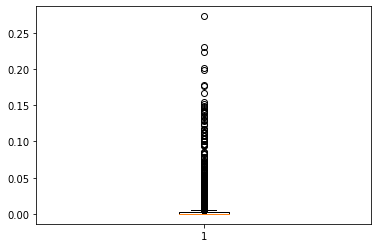

In [260]:
plt.boxplot(gdf_final['ratio-adjusted'])
plt.plot()

In [261]:
gdf_final.sort_values(by='ratio',ascending=False).head(5)

,縣市,行政區,村里,geometry,戶口,人口,會員數,消費額,平均消費額,site,會員數-adjusted,ratio,ratio-adjusted,ratio2,ratio2-adjusted,會員數-show,會員數-adjusted-show,percent,percent-adjusted
5850,台中市,南屯區,惠中里,"POLYGON ((120.64169 24.15115, 120.64266 24.151...",3671,9752,894.0,4509887.78,5045.0,台中市南屯區惠中里,1001.377258,0.243530,0.272781,0.243530,0.272781,894,1001,24.4%,27.3%
5853,台中市,南屯區,大業里,"POLYGON ((120.65382 24.15580, 120.65349 24.155...",2992,8115,615.0,2772107.85,4507.0,台中市南屯區大業里,688.866906,0.205548,0.230236,0.205548,0.230236,615,689,20.6%,23.0%
2154,台中市,南屯區,文心里,"POLYGON ((120.64874 24.14678, 120.64922 24.146...",1797,4790,359.0,1507487.99,4199.0,台中市南屯區文心里,402.119056,0.199777,0.223772,0.199777,0.223772,359,402,20.0%,22.4%
5849,台中市,西區,公正里,"POLYGON ((120.65511 24.15045, 120.65511 24.150...",2853,7612,505.0,2060373.04,4080.0,台中市西區公正里,573.444259,0.177007,0.200997,0.177007,0.200997,505,573,17.7%,20.1%
5855,台中市,西屯區,何南里,"POLYGON ((120.65375 24.16038, 120.65428 24.160...",1959,4886,329.0,933566.98,2838.0,台中市西屯區何南里,388.405926,0.167943,0.198267,0.167943,0.198267,329,388,16.8%,19.8%


In [262]:
gdf_final.to_excel(r'C:\Users\RT009223\TestriteGroup\滲透率專案\04_TLW\result\1A39_2020Q4.xlsx',index=0)

# 特力屋店點(部分)

In [263]:
TLW=pd.read_excel('特力屋店點.xlsx')
TLW

,name,addr,type,lat,lon,location
0,1A01南崁店,桃園市蘆竹區中正路1號,0,25.040152,121.294723,桃園市
1,1A02新莊店,新北市新莊區中正路620號,0,25.029195,121.422794,新北市
2,1A03大順店,高雄市苓雅區武廟路218號,0,22.631806,120.324095,高雄市
3,1A04台中店,台中市南區復興路一段359號3F,1,24.114689,120.654338,台中市
4,1A05嘉義店,嘉義市東區忠孝路547號,0,23.500618,120.448599,嘉義市
5,1A06台南店,台南市北區文賢路720號,0,23.010776,120.193971,台南市
6,1A07內湖店,台北市內湖區新湖三路23號,0,25.062030,121.574170,台北市
7,1A08平鎮店,桃園縣平鎮市環南路二段261號,0,24.940717,121.214822,桃園市
8,1A09士林店,台北市士林區基河路258號,0,25.092606,121.520207,台北市
9,1A10彰化店,彰化縣和美鎮彰美路二段49號,0,24.092316,120.532855,彰化縣


In [264]:
MRT=pd.read_excel('捷運站經緯度.xlsx')
MRT.head()

,station_code,construction_id,station_name_tw,station_name_en,line_code,line_name,address,lat,lon,color
0,BR01,BR13,動物園,Taipei Zoo,BR,文湖線,台北市文山區新光路二段32號,24.998197,121.579338,#c48c31
1,BR02,BR12,木柵,Muzha,BR,文湖線,台北市文山區木柵路四段135號,24.998241,121.573145,#c48c31
2,BR03,BR11,萬芳社區,Wanfang Community,BR,文湖線,台北市文山區萬芳路60號,24.998585,121.568102,#c48c31
3,BR04,BR10,萬芳醫院,Wanfang Hospital,BR,文湖線,台北市文山區興隆路三段113號,24.999386,121.558152,#c48c31
4,BR05,BR9,辛亥,Xinhai,BR,文湖線,台北市文山區辛亥路四段128號,25.005475,121.557107,#c48c31


In [265]:
sp=pd.read_excel('中永和區幼兒園國中小地址0305.xlsx')
sp.head()

,type,name,lon,lat
0,替代品,小北新北景新店,121.506180,25.000555
1,替代品,小北新北中和店,121.471899,25.018582
2,替代品,小北新北竹林店,121.519093,25.015559
3,替代品,小北新北福和店,121.523341,25.008753
4,替代品,小北新北民族店,121.469955,25.008326


# 畫圖

In [266]:
gdf_final.columns

Index(['縣市', '行政區', '村里', 'geometry', '戶口', '人口', '會員數', '消費額', '平均消費額',
       'site', '會員數-adjusted', 'ratio', 'ratio-adjusted', 'ratio2',
       'ratio2-adjusted', '會員數-show', '會員數-adjusted-show', 'percent',
       'percent-adjusted'],
      dtype='object')

In [267]:
# 各車站定位
台北車站=[25.047741, 121.517384]
中壢車站=[24.953737, 121.225607]
台中車站=[24.137264, 120.686669]
嘉義車站=[23.479119, 120.441138]


print(gdf_final['縣市'].unique())
site=['基隆市','新北市', '台北市','桃園市','新竹縣','新竹市','苗栗縣','台中市','彰化縣','南投縣',
      '雲林縣','嘉義縣','嘉義市','台南市',
      '高雄市','屏東縣','宜蘭縣','花蓮縣','台東縣',
      '澎湖縣','金門縣','連江縣']

site_colors={'基隆市':'#6e5e4c','新北市':'#6e5e4c', '台北市':'#6e5e4c',
            '桃園市':'#968278','新竹縣':'#968278','新竹市':'#968278','苗栗縣':'#968278',
            '台中市':'#6e5e4c','彰化縣':'#6e5e4c','南投縣':'#6e5e4c','澎湖縣':'#6e5e4c','金門縣':'#6e5e4c','連江縣':'#6e5e4c',
            '雲林縣':'#968278','嘉義縣':'#968278','嘉義市':'#968278','台南市':'#968278',
            '高雄市':'#6e5e4c','屏東縣':'#6e5e4c',
            '宜蘭縣':'#968278','花蓮縣':'#968278','台東縣':'#968278'}

#想畫顏色的變數
variable='ratio2-adjusted'

#設定色階
gdf_final['id']=gdf_final.index
color=gdf_final.set_index('id')[variable]

high=round(color.max(),1)
low=color.min()
p=high/8
print(p)

colorscale = branca.colormap.linear.YlOrRd_09.scale(low, high)
#colorscale = branca.colormap.linear.YlGnBu_09.scale(low, 0.4)
colorscale




['高雄市' '連江縣' '屏東縣' '花蓮縣' '新竹市' '台東縣' '台中市' '嘉義縣' '桃園市' '南投縣' '雲林縣' '新竹縣'
 '嘉義市' '台南市' '基隆市' '澎湖縣' '金門縣' '苗栗縣' '宜蘭縣' '彰化縣' '新北市' '台北市']
0.0375


In [268]:
print(color.max())
print(color.isna().sum())
colorscale

0.2727805115748545
0


In [269]:
# 顏色 style
def style_function(feature):
    colors = color.get(int(feature['id']), None)
    site_color=site_colors.get(feature['properties']['縣市'])
    return {
        'fillOpacity': 0.5,
        'weight': 1,
        'color':site_color,
        'fillColor': '#fff' if colors is None else colorscale(colors)
    }

In [270]:
# 設定圖例
colormap=colorscale.to_step(index=[0, p*1, p*2, p*3, p*4,p*5,p*6,p*7,p*8])
#colormap.caption ='The Number of Loss Member'
colormap.caption ='Member Penetration Rates'
#colormap.caption ='Average Consumption'

In [271]:
#商圈
'''
#1A10彰化店
gdf_boundry=gdf_final.loc[ (gdf_final['行政區'].isin(['彰化市','和美鎮']))|\
                          (gdf_final['行政區'].isin(['伸港鄉','線西鄉']))|\
                          ( (gdf_final['行政區'].isin(['鹿港鎮'])) & (gdf_final['ratio']>0.1) )|\
                          ( (gdf_final['行政區'].isin(['秀水鄉'])) & (gdf_final['ratio']>0.1) ), :]
'''
'''
#1A12員林店
gdf_boundry=gdf_final.loc[ ( (gdf_final['縣市']=='彰化縣')& (gdf_final['行政區'].isin(['員林市','大村鄉'])))\
                          |( (gdf_final['縣市']=='彰化縣')& (gdf_final['行政區'].isin(['埔心鄉','永靖鄉'])))\
                          |( (gdf_final['縣市']=='彰化縣')& (gdf_final['行政區'].isin(['花壇鄉'])) & (gdf_final['ratio']>0.1) )\
                          |( (gdf_final['縣市']=='彰化縣')& (gdf_final['行政區'].isin(['社頭鄉'])) & (gdf_final['ratio']>0.1) )\
                          , :]
'''
'''
#1A17中和店
gdf_boundry=gdf_final.loc[ ( (gdf_final['縣市']=='新北市')& (gdf_final['行政區'].isin(['中和區','永和區'])))\
                          |( (gdf_final['縣市']=='新北市')& (gdf_final['行政區'].isin(['板橋區'])) & (gdf_final['ratio-adjusted']>0.1) )\
                          |( (gdf_final['縣市']=='台北市')& (gdf_final['行政區'].isin(['萬華區'])) & (gdf_final['ratio-adjusted']>0.1) )\
                          , :]

'''
#1A39大墩店
gdf_boundry=gdf_final.loc[ ( (gdf_final['縣市']=='台中市')& (gdf_final['行政區'].isin(['南屯區'])) & (gdf_final['ratio-adjusted']>0.1) )\
                          |( (gdf_final['縣市']=='台中市')& (gdf_final['行政區'].isin(['西屯區'])) & (gdf_final['ratio-adjusted']>0.1) )\
                          |( (gdf_final['縣市']=='台中市')& (gdf_final['行政區'].isin(['北區'])) & (gdf_final['ratio-adjusted']>0.1) )\
                          |( (gdf_final['縣市']=='台中市')& (gdf_final['行政區'].isin(['西區'])) & (gdf_final['ratio-adjusted']>0.1) )\
                          |( (gdf_final['縣市']=='台中市')& (gdf_final['行政區'].isin(['南區'])) & (gdf_final['ratio-adjusted']>0.1) )\
                          |( (gdf_final['縣市']=='台中市')& (gdf_final['行政區'].isin(['烏日區'])) & (gdf_final['ratio-adjusted']>0.1) )\
                          , :]

gdf_boundry=gdf_boundry.dissolve(by='行政區').reset_index()
gdf_boundry

,行政區,geometry,縣市,村里,戶口,人口,會員數,消費額,平均消費額,site,會員數-adjusted,ratio,ratio-adjusted,ratio2,ratio2-adjusted,會員數-show,會員數-adjusted-show,percent,percent-adjusted,id
0,南區,"POLYGON ((120.66049 24.11690, 120.66056 24.116...",台中市,福平里,2350,6224,224.0,674806.79,3013.0,台中市南區福平里,253.854813,0.095319,0.108023,0.095319,0.108023,224,254,9.5%,10.8%,2072
1,南屯區,"POLYGON ((120.64112 24.11743, 120.64015 24.116...",台中市,南屯里,4024,10999,421.0,1838941.62,4368.0,台中市南屯區南屯里,471.565800,0.104622,0.117188,0.104622,0.117188,421,472,10.5%,11.7%,2104
2,烏日區,"POLYGON ((120.65024 24.11149, 120.65069 24.109...",台中市,前竹里,595,1975,62.0,214638.17,3462.0,台中市烏日區前竹里,69.641836,0.104202,0.117045,0.104202,0.117045,62,70,10.4%,11.7%,5925
3,西區,"POLYGON ((120.66428 24.14010, 120.66451 24.140...",台中市,東昇里,1089,2835,99.0,582002.26,5879.0,台中市西區東昇里,112.417785,0.090909,0.103230,0.090909,0.103230,99,112,9.1%,10.3%,2083
4,西屯區,"POLYGON ((120.65375 24.16038, 120.65428 24.160...",台中市,何南里,1959,4886,329.0,933566.98,2838.0,台中市西屯區何南里,388.405926,0.167943,0.198267,0.167943,0.198267,329,388,16.8%,19.8%,5855


In [273]:
# 篩選縣市
site2=site[7:8]
print(site2)

['台中市']


In [277]:
mm=folium.Map(location=台中車站,zoom_start=14)
dis=1
if dis==1:
    folium.GeoJson(
        gdf_boundry,
        style_function = lambda x: {
            'color': 'black',
            'weight': 4,
            'fillOpacity': 0
        },
        name='Business District').add_to(mm)

for s in site2:
    folium.GeoJson(
        gdf_final[gdf_final['縣市']==s][['geometry','縣市','行政區','村里','戶口','人口','會員數-show','percent','會員數-adjusted-show','percent-adjusted','平均消費額']],
        name=s, 
        style_function=style_function,
        highlight_function=lambda x: {'weight':3, 
                                        'color':site_colors.get(x['properties']['縣市']),
                                        'fillOpacity':0.75},
        smooth_factor=2.0,
        tooltip=folium.features.GeoJsonTooltip(fields=['縣市','行政區','村里','戶口','percent-adjusted'],
                                                  aliases=['縣市','行政區','村里','戶數','滲透率'], 
                                                  labels=True, 
                                                  sticky=True,
                                                  toLocaleString=True
                                                 )
    ).add_to(mm)
    

#MRT
if 1==0:
    #MRT_cluster = MarkerCluster(name='MRT').add_to(mm)
    fg1=folium.FeatureGroup(name='MRT', show=True)
    for i in range(MRT.shape[0]):
        if MRT.line_code[i] in ['Y','O']:
            iframe = IFrame(html=heading3(utf2asc(MRT.station_name_tw[i])),width=250,height=50)
            popup = folium.Popup(iframe)
            folium.Marker(location=[MRT.lat[i], MRT.lon[i]],
                           popup=popup,
                           icon=folium.Icon(icon='train',
                                            color='black',
                                            icon_color=MRT.color[i],
                                            prefix='fa')).add_to(fg1)
    mm.add_child(fg1)
    #mm.add_child(MRT_cluster)

#其他1
if 1==0:
    fg2=folium.FeatureGroup(name='幼兒園', show=True)
    fg3=folium.FeatureGroup(name='國小', show=True)
    fg4=folium.FeatureGroup(name='國中', show=True)
    fg5=folium.FeatureGroup(name='互補品', show=True)
    fg6=folium.FeatureGroup(name='替代品', show=True)
    for i in range(sp.shape[0]):
        if sp.type[i] in ['幼兒園']:            
            folium.Circle(location=[sp.lat[i],sp.lon[i]],
                             color='#0000C6', # Circle 顏色
                             radius=25, # Circle 寬度
                             fill=True, # 填滿中間區域
                             fill_opacity=0.7 # 設定透明度
                             ).add_to(fg2)
        elif sp.type[i] in ['國小']:
            folium.Circle(location=[sp.lat[i],sp.lon[i]],
                             color='#64A600', # Circle 顏色
                             radius=25, # Circle 寬度
                             fill=True, # 填滿中間區域
                             fill_opacity=0.7 # 設定透明度
                             ).add_to(fg3)
        elif sp.type[i] in ['國中']:
            folium.Circle(location=[sp.lat[i],sp.lon[i]],
                             color='#8F4586', # Circle 顏色
                             radius=25, # Circle 寬度
                             fill=True, # 填滿中間區域
                             fill_opacity=0.7 # 設定透明度
                             ).add_to(fg4)
        elif sp.type[i] in ['互補品']:
            folium.Circle(location=[sp.lat[i],sp.lon[i]],
                             color='#EA0000', # Circle 顏色
                             radius=25, # Circle 寬度
                             fill=True, # 填滿中間區域
                             fill_opacity=0.7 # 設定透明度
                             ).add_to(fg5)
        elif sp.type[i] in ['替代品']:
            folium.Circle(location=[sp.lat[i],sp.lon[i]],
                             color='#F9F900', # Circle 顏色
                             radius=25, # Circle 寬度
                             fill=True, # 填滿中間區域
                             fill_opacity=0.7 # 設定透明度
                             ).add_to(fg6)
    mm.add_child(fg2)
    mm.add_child(fg3)
    mm.add_child(fg4)
    mm.add_child(fg5)
    mm.add_child(fg6)

    
for i in range(TLW.shape[0]):
    if TLW.type[i]==0:
        iframe = IFrame(html=heading3(utf2asc(TLW.name[i])),width=250,height=50)
        popup = folium.Popup(iframe)
        folium.Marker(location=[TLW.lat[i], TLW.lon[i]],
                       popup=popup,
                       icon=folium.Icon(icon='info-sign',
                                        color='orange')).add_to(mm)
    elif TLW.type[i]==2:
        iframe = IFrame(html=heading3(utf2asc(TLW.name[i])),width=250,height=50)
        popup = folium.Popup(iframe)
        folium.Marker(location=[TLW.lat[i], TLW.lon[i]],
                       popup=popup,
                       icon=folium.Icon(icon='info-sign',
                                        color='pink')).add_to(mm)
    else:  
        iframe = IFrame(html=heading3(utf2asc(TLW.name[i])),width=250,height=50)
        popup = folium.Popup(iframe)
        folium.Marker(location=[TLW.lat[i], TLW.lon[i]],
                       popup=popup,
                       icon=folium.Icon(icon='info-sign',
                                        color='gray')).add_to(mm)


colormap.add_to(mm)


folium.LayerControl().add_to(mm)


In [278]:
#mm

In [279]:
mm.save(r'C:\Users\RT009223\TestriteGroup\滲透率專案\04_TLW\result\台灣2020Q4_1A39(滲透率).html')